ViT-B16 with cutmix applied:

In [14]:

# Import necessary programmes  
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets, models
from torchvision.models import ViT_B_16_Weights
from torchvision.transforms.v2 import CutMix  

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Transforms - loads default pretrained weights for ViT-B_16 (trained on ImageNet)
weights = ViT_B_16_Weights.DEFAULT
transform = weights.transforms()

# Dictionary-style dataset and dataloader setup
data_transforms = {
    'train': transform,
    'valid': transform,
    'test': transform
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load ViT-B_16 model with pretrained weights
model = models.vit_b_16(weights=weights)
# Replace just the head layer 
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 3 transformer blocks + heads 
for name, param in model.named_parameters():
    if any(layer in name for layer in ["encoder_layer_9", "encoder_layer_10", "encoder_layer_11"]) or "heads" in name:
        param.requires_grad = True

model.to(device)

# Loss and optimiser for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

Epoch 1/5:   1%|▏         | 3/225 [01:01<1:16:06, 20.57s/it]


KeyboardInterrupt: 

In [6]:
torch.save(model.state_dict(), "vit_b16_cutmix_only.pth")

In [19]:
# Define reshape_transform for ViT
def vit_reshape_transform(tensor):
    result = tensor[:, 1:, :]
    result = result.reshape(result.size(0), 14, 14, -1)
    result = result.permute(0, 3, 1, 2)  
    return result

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = models.vit_b_16(pretrained=False)  
model.heads.head = nn.Linear(model.heads.head.in_features, 50)  

model.load_state_dict(torch.load("vit_b16_cutmix_only.pth", map_location=device))  
model.to(device)
model.eval()

# Load and preprocess image
image_path = "../data/kaggle-dataset/archive/test/POLYPHEMUS MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0

# Use enhanced fine-tuning transform (instead of default weights)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply transform to PIL image 
input_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Target Layer (use final encoder layer norm)
target_layer = model.encoder.ln 

# Score-CAM with reshape transform
cam = ScoreCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)

# Generate CAM heatmap 
grayscale_cam = cam(input_tensor=input_tensor)[0]
grayscale_cam = np.clip(grayscale_cam * 1.5, 0, 1)  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/vit_b16_ft/score-cam-cutmix-polyphemus-1.jpg") 
cv2.imwrite(str(output_path), visualisation)

 21%|██        | 10/48 [00:25<01:38,  2.59s/it]


KeyboardInterrupt: 

In [ ]:
# Define reshape_transform for ViT
def vit_reshape_transform(tensor):
    result = tensor[:, 1:, :]
    result = result.reshape(result.size(0), 14, 14, -1)
    result = result.permute(0, 3, 1, 2)  
    return result

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = models.vit_b_16(pretrained=False)  
model.heads.head = nn.Linear(model.heads.head.in_features, 50)  

model.load_state_dict(torch.load("vit_b16_cutmix_only.pth", map_location=device))  
model.to(device)
model.eval()

# Load and preprocess image
image_path = "../data/kaggle-dataset/archive/test/GARDEN TIGER MOTH/5.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0

# Use enhanced fine-tuning transform (instead of default weights)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply transform to PIL image 
input_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Target Layer (use final encoder layer norm)
target_layer = model.encoder.ln 

# Score-CAM with reshape transform
cam = ScoreCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)

# Generate CAM heatmap 
grayscale_cam = cam(input_tensor=input_tensor)[0]
grayscale_cam = np.clip(grayscale_cam * 1.5, 0, 1)  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/vit_b16_ft/score-cam-cutmix-garden-tiger-5.jpg") 
cv2.imwrite(str(output_path), visualisation)

In [ ]:
# Define reshape_transform for ViT
def vit_reshape_transform(tensor):
    result = tensor[:, 1:, :]
    result = result.reshape(result.size(0), 14, 14, -1)
    result = result.permute(0, 3, 1, 2)  
    return result

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = models.vit_b_16(pretrained=False)  
model.heads.head = nn.Linear(model.heads.head.in_features, 50)  

model.load_state_dict(torch.load("vit_b16_cutmix_only.pth", map_location=device))  
model.to(device)
model.eval()

# Load and preprocess image
image_path = "../data/kaggle-dataset/archive/test/GARDEN TIGER MOTH/4.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0

# Use enhanced fine-tuning transform (instead of default weights)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply transform to PIL image 
input_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Target Layer (use final encoder layer norm)
target_layer = model.encoder.ln 

# Score-CAM with reshape transform
cam = ScoreCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)

# Generate CAM heatmap 
grayscale_cam = cam(input_tensor=input_tensor)[0]
grayscale_cam = np.clip(grayscale_cam * 1.5, 0, 1)  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/vit_b16_ft/score-cam-cutmix-garden-tiger-4.jpg") 
cv2.imwrite(str(output_path), visualisation)

We will now apply standard transformations to the ViT-B16 model:

Epoch 1/5: 100%|██████████| 225/225 [38:27<00:00, 10.25s/it]


Epoch 1: Train Acc: 67.90%, Val Acc: 97.60%


Epoch 2/5: 100%|██████████| 225/225 [29:40<00:00,  7.91s/it]


Epoch 2: Train Acc: 74.50%, Val Acc: 97.60%


Epoch 3/5: 100%|██████████| 225/225 [28:40<00:00,  7.65s/it]


Epoch 3: Train Acc: 76.92%, Val Acc: 97.20%


Epoch 4/5: 100%|██████████| 225/225 [18:20<00:00,  4.89s/it]


Epoch 4: Train Acc: 77.03%, Val Acc: 96.80%


Epoch 5/5: 100%|██████████| 225/225 [18:30<00:00,  4.94s/it]


Epoch 5: Train Acc: 76.11%, Val Acc: 97.20%


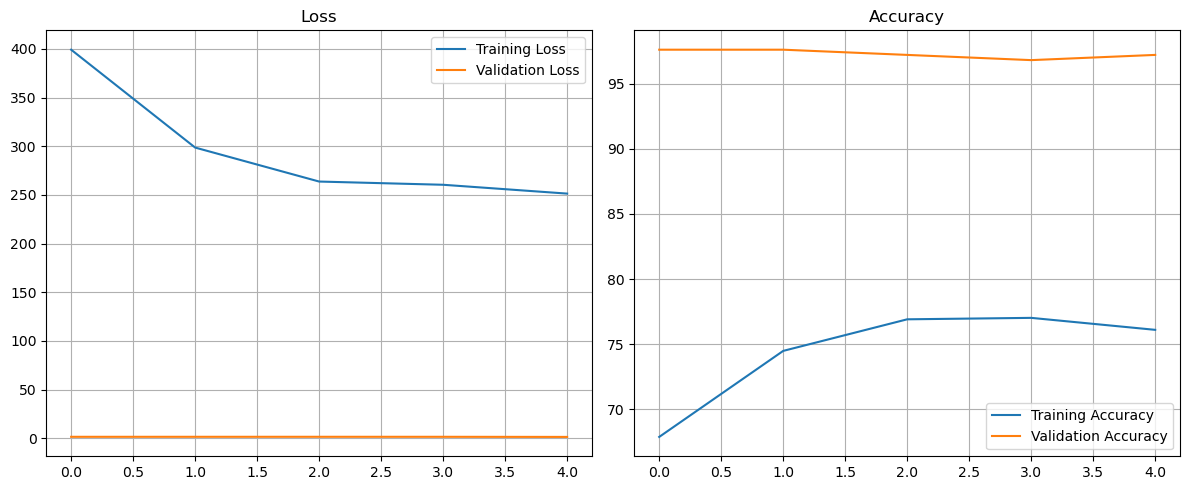

Test Accuracy: 99.60%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      1.00      1.00         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [ ]:
# Import necessary programmes  
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets, models
from torchvision.models import ViT_B_16_Weights
from torchvision.transforms.v2 import CutMix  

# Import necessary libraries
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix  
from timm import create_model

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/targeted_augmented_dataset")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 blocks of serial_blocks4 + norm4 + head 
for name, param in model.named_parameters():
    if any([k in name for k in ["serial_blocks4.5", "serial_blocks4.6", "serial_blocks4.7", "norm4", "head"]]):
        param.requires_grad = True

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load ViT-B_16 model with pretrained weights
weights = ViT_B_16_Weights.DEFAULT
model = models.vit_b_16(weights=weights)
# Replace just the head layer 
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 3 transformer blocks + heads 
for name, param in model.named_parameters():
    if any(layer in name for layer in ["encoder_layer_9", "encoder_layer_10", "encoder_layer_11"]) or "heads" in name:
        param.requires_grad = True

model.to(device)

# Loss and optimiser for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [11]:
torch.save(model.state_dict(), "vit_b16_standard_augmentations.pth")

Further transformations will be applied to the commonly confused species pairs:

Epoch 1/5: 100%|██████████| 591/591 [2:00:38<00:00, 12.25s/it]  


Epoch 1: Train Acc: 71.22%, Val Acc: 95.20%


Epoch 2/5: 100%|██████████| 591/591 [1:16:34<00:00,  7.77s/it]


Epoch 2: Train Acc: 76.58%, Val Acc: 97.20%


Epoch 3/5: 100%|██████████| 591/591 [1:15:42<00:00,  7.69s/it]


Epoch 3: Train Acc: 78.72%, Val Acc: 96.80%


Epoch 4/5: 100%|██████████| 591/591 [51:30<00:00,  5.23s/it] 


Epoch 4: Train Acc: 78.04%, Val Acc: 96.80%


Epoch 5/5: 100%|██████████| 591/591 [54:22<00:00,  5.52s/it]


Epoch 5: Train Acc: 78.69%, Val Acc: 96.80%


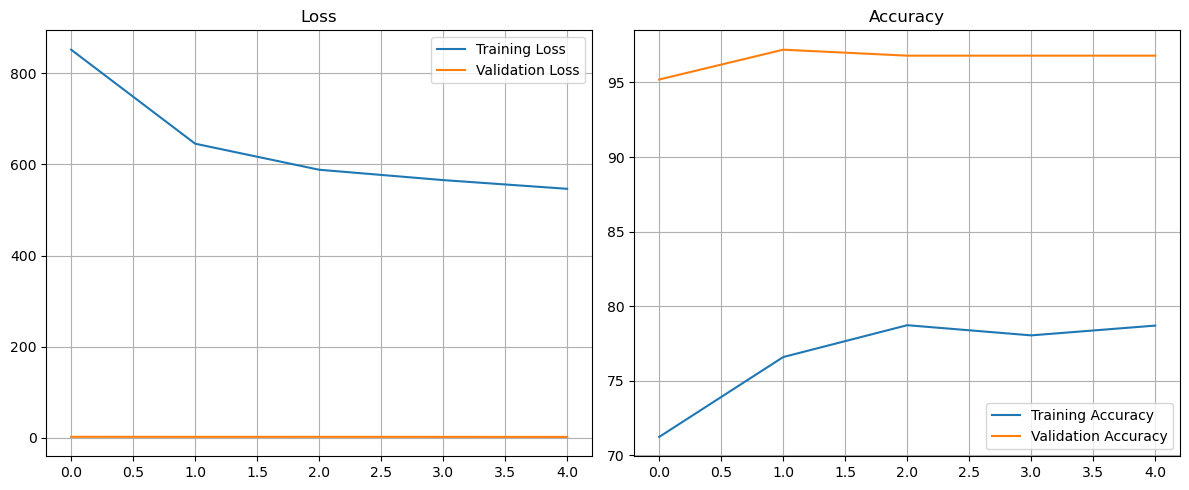

Test Accuracy: 98.80%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       0.83      1.00      0.91         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      1.00      1.00         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [ ]:
# Import necessary programmes  
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets, models
from torchvision.models import ViT_B_16_Weights
from torchvision.transforms.v2 import CutMix  

# Import necessary libraries
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix  
from timm import create_model

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/targeted_augmented_dataset")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 blocks of serial_blocks4 + norm4 + head 
for name, param in model.named_parameters():
    if any([k in name for k in ["serial_blocks4.5", "serial_blocks4.6", "serial_blocks4.7", "norm4", "head"]]):
        param.requires_grad = True

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/targeted_augmented_dataset")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load ViT-B_16 model with pretrained weights
weights = ViT_B_16_Weights.DEFAULT
model = models.vit_b_16(weights=weights)
# Replace just the head layer 
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 3 transformer blocks + heads 
for name, param in model.named_parameters():
    if any(layer in name for layer in ["encoder_layer_9", "encoder_layer_10", "encoder_layer_11"]) or "heads" in name:
        param.requires_grad = True

model.to(device)

# Loss and optimiser for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [13]:
torch.save(model.state_dict(), "vit_b16_final_augmentations.pth")

Lets look at how the targeted augmentations have helped confused pairs in the ViT-B16 model:

In [ ]:
# Define reshape_transform for ViT
def vit_reshape_transform(tensor):
    result = tensor[:, 1:, :]
    result = result.reshape(result.size(0), 14, 14, -1)
    result = result.permute(0, 3, 1, 2)  
    return result

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = models.vit_b_16(pretrained=False)  
model.heads.head = nn.Linear(model.heads.head.in_features, 50)  

model.load_state_dict(torch.load("vit_b16_final_augmentations.pth", map_location=device))  
model.to(device)
model.eval()

# Load and preprocess image
image_path = "../data/kaggle-dataset/archive/test/OWL MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0

# Use enhanced fine-tuning transform (instead of default weights)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply transform to PIL image 
input_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Target Layer (use final encoder layer norm)
target_layer = model.encoder.ln 

# Score-CAM with reshape transform
cam = ScoreCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)

# Generate CAM heatmap 
grayscale_cam = cam(input_tensor=input_tensor)[0]
grayscale_cam = np.clip(grayscale_cam * 1.5, 0, 1)  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/vit_b16_ft/score-cam-final-augmentations-owl-1.jpg") 
cv2.imwrite(str(output_path), visualisation)

In [ ]:
# Define reshape_transform for ViT
def vit_reshape_transform(tensor):
    result = tensor[:, 1:, :]
    result = result.reshape(result.size(0), 14, 14, -1)
    result = result.permute(0, 3, 1, 2)  
    return result

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = models.vit_b_16(pretrained=False)  
model.heads.head = nn.Linear(model.heads.head.in_features, 50)  

model.load_state_dict(torch.load("vit_b16_final_augmentations.pth", map_location=device))  
model.to(device)
model.eval()

# Load and preprocess image
image_path = "../data/kaggle-dataset/archive/test/POLYPHEMUS MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0

# Use enhanced fine-tuning transform (instead of default weights)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply transform to PIL image 
input_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Target Layer (use final encoder layer norm)
target_layer = model.encoder.ln 

# Score-CAM with reshape transform
cam = ScoreCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)

# Generate CAM heatmap 
grayscale_cam = cam(input_tensor=input_tensor)[0]
grayscale_cam = np.clip(grayscale_cam * 1.5, 0, 1)  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/vit_b16_ft/score-cam-final-augmentations-polyphemus-1.jpg") 
cv2.imwrite(str(output_path), visualisation)

In [ ]:
# Base path to CAM outputs
base_path = Path("../cam_outputs/vit_b16_ft")

# Loop over image indices 1–5
fig, axs = plt.subplots(5, 2, figsize=(10, 20))  # 5 images, 2 columns

for i in range(1, 6):
    # Construct file paths
    std_path = base_path / f"score-cam-cutmix-owl-{i}.jpg"
    tgt_path = base_path / f"score-cam-final-augmentations-owl-{i}-.jpg"

    # Load images
    img_std = mpimg.imread(std_path)
    img_tgt = mpimg.imread(tgt_path)

    # Plot standard augmentation version
    axs[i - 1, 0].imshow(img_std)
    axs[i - 1, 0].axis('off')
    axs[i - 1, 0].set_title(f"Sixspot Burnet Moth {i} – Standard Augmentation")

    # Plot targeted augmentation version
    axs[i - 1, 1].imshow(img_tgt)
    axs[i - 1, 1].axis('off')
    axs[i - 1, 1].set_title(f"Sixspot Burnet Moth {i} – Targeted Augmentation")

plt.tight_layout()
plt.show()


For more in-depth fine-tuning, we will unfreeze unfreeze encoder layers 10 and 11 (two final transformer blocks) and the classification head. We'll also apply layer-wise learning rates and extended training:

Epoch 1/15: 100%|██████████| 394/394 [28:00<00:00,  4.27s/it]


Epoch 1: Train Acc: 54.95%, Val Acc: 93.20%


Epoch 2/15: 100%|██████████| 394/394 [24:33<00:00,  3.74s/it]


Epoch 2: Train Acc: 71.56%, Val Acc: 94.80%


Epoch 3/15: 100%|██████████| 394/394 [21:56<00:00,  3.34s/it]


Epoch 3: Train Acc: 72.68%, Val Acc: 96.40%


Epoch 4/15: 100%|██████████| 394/394 [22:04<00:00,  3.36s/it]


Epoch 4: Train Acc: 74.75%, Val Acc: 95.60%


Epoch 5/15: 100%|██████████| 394/394 [22:09<00:00,  3.38s/it]


Epoch 5: Train Acc: 74.91%, Val Acc: 96.80%


Epoch 6/15: 100%|██████████| 394/394 [22:14<00:00,  3.39s/it]


Epoch 6: Train Acc: 75.09%, Val Acc: 96.00%


Epoch 7/15: 100%|██████████| 394/394 [22:13<00:00,  3.39s/it]


Epoch 7: Train Acc: 76.05%, Val Acc: 96.40%


Epoch 8/15: 100%|██████████| 394/394 [22:12<00:00,  3.38s/it]


Epoch 8: Train Acc: 74.58%, Val Acc: 96.40%


Epoch 9/15: 100%|██████████| 394/394 [22:09<00:00,  3.37s/it]


Epoch 9: Train Acc: 75.71%, Val Acc: 96.80%


Epoch 10/15: 100%|██████████| 394/394 [22:09<00:00,  3.37s/it]


Epoch 10: Train Acc: 76.34%, Val Acc: 96.80%
Early stopping triggered.


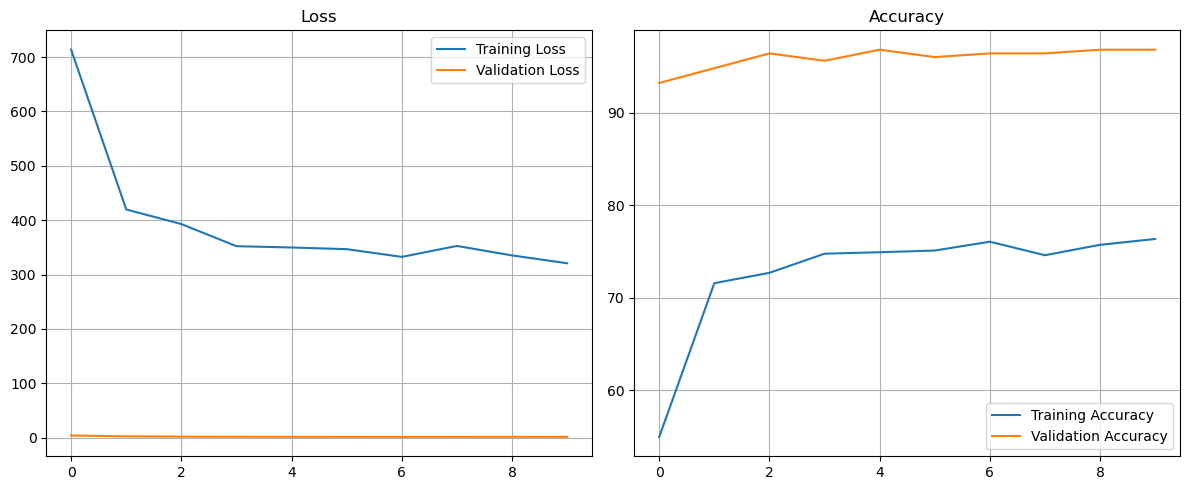

Test Accuracy: 97.60%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      0.80      0.89         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       0.83      1.00      0.91         5
           CLEARWING MOTH       1.00      1.00      1.00         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [ ]:
# Import necessary programmes  
from pathlib import Path
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image

from torchvision import transforms, datasets, models
from torchvision.models import ViT_B_16_Weights
from torchvision.transforms.v2 import CutMix  

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/targeted_augmented_dataset")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load ViT-B_16 model with pretrained weights
weights = ViT_B_16_Weights.DEFAULT
model = models.vit_b_16(weights=weights)
# Replace just the head layer 
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Deeper unfreezing - unfreeze last 4 transformer blocks + heads
for param in model.parameters():
    param.requires_grad = False

# Unfreeze encoder layers 8, 9, 10, 11 + heads (last 4 transformer blocks)
for name, param in model.named_parameters():
    if any(layer in name for layer in ["encoder.layers.8", "encoder.layers.9", "encoder.layers.10", "encoder.layers.11"]) or "heads" in name:
        param.requires_grad = True

model.to(device)

# Discriminative learning rates setup
base_lr = 1e-3
param_groups = []

# Group parameters by encoder layers
for name, param in model.named_parameters():
    if param.requires_grad:
        if "encoder.layers.8" in name:
            param_groups.append({'params': [param], 'lr': base_lr * 0.1})  # Conservative
        elif "encoder.layers.9" in name:
            param_groups.append({'params': [param], 'lr': base_lr * 0.3})  # Moderate-low
        elif "encoder.layers.10" in name:
            param_groups.append({'params': [param], 'lr': base_lr * 0.6})  # Moderate-high
        elif "encoder.layers.11" in name:
            param_groups.append({'params': [param], 'lr': base_lr * 0.8})  # Aggressive
        elif "heads" in name:
            param_groups.append({'params': [param], 'lr': base_lr})        # Most aggressive

optimizer = optim.Adam(param_groups, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.5)

# Count trainable parameters for reference
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Enhanced fine-tuning: {trainable_params:,}/{total_params:,} trainable params ({100*trainable_params/total_params:.1f}%)")

# Loss and optimiser for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")
    
    # Step the scheduler
    scheduler.step()

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [9]:
torch.save(model.state_dict(), "vit_b16_final_finetuning.pth")

Full fine-tuning appears to have reduced model accuracy, therefore we will implement a lower level of fine-tuning to see if this helps the model:

Epoch 1/15: 100%|██████████| 394/394 [20:06<00:00,  3.06s/it]


Epoch 1: Train Acc: 54.95%, Val Acc: 93.20%


Epoch 2/15: 100%|██████████| 394/394 [24:28<00:00,  3.73s/it]


Epoch 2: Train Acc: 71.56%, Val Acc: 94.80%


Epoch 3/15: 100%|██████████| 394/394 [38:39<00:00,  5.89s/it]


Epoch 3: Train Acc: 72.68%, Val Acc: 96.40%


Epoch 4/15: 100%|██████████| 394/394 [37:01<00:00,  5.64s/it]


Epoch 4: Train Acc: 74.75%, Val Acc: 95.60%


Epoch 5/15: 100%|██████████| 394/394 [54:08<00:00,  8.25s/it]


Epoch 5: Train Acc: 74.91%, Val Acc: 96.80%


Epoch 6/15: 100%|██████████| 394/394 [56:30<00:00,  8.61s/it]  


Epoch 6: Train Acc: 75.09%, Val Acc: 96.00%


Epoch 7/15: 100%|██████████| 394/394 [41:58<00:00,  6.39s/it] 


Epoch 7: Train Acc: 76.05%, Val Acc: 96.40%


Epoch 8/15: 100%|██████████| 394/394 [41:37<00:00,  6.34s/it]


Epoch 8: Train Acc: 74.58%, Val Acc: 96.40%


Epoch 9/15: 100%|██████████| 394/394 [37:55<00:00,  5.78s/it]


Epoch 9: Train Acc: 75.71%, Val Acc: 96.80%


Epoch 10/15: 100%|██████████| 394/394 [35:34<00:00,  5.42s/it]


Epoch 10: Train Acc: 76.34%, Val Acc: 96.80%
Early stopping triggered.


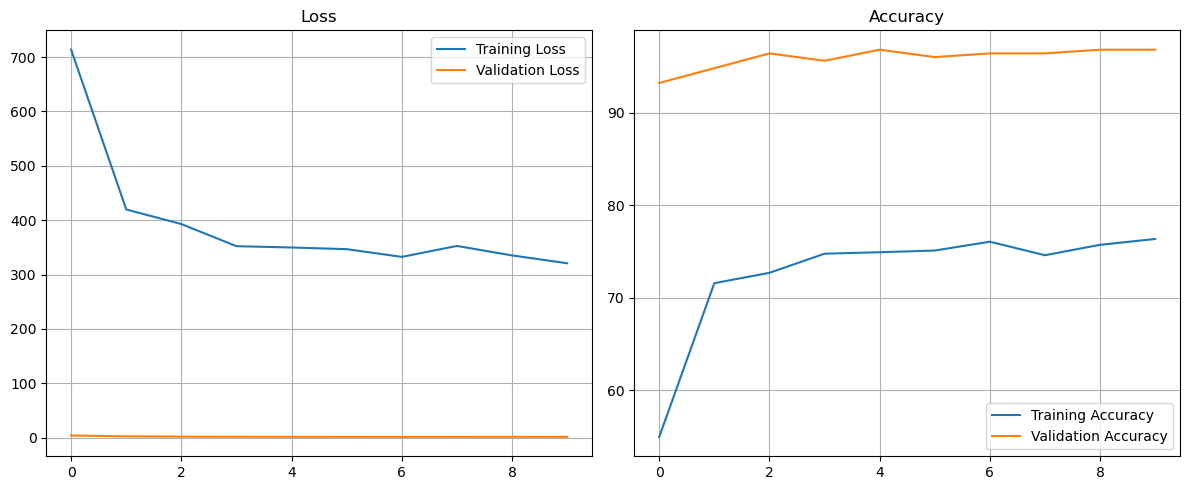

Test Accuracy: 97.60%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      0.80      0.89         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       0.83      1.00      0.91         5
           CLEARWING MOTH       1.00      1.00      1.00         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [10]:
# Import necessary programmes 
from pathlib import Path
import copy
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

from torchvision import transforms, datasets, models
from torchvision.models import ViT_B_16_Weights
from torchvision.transforms.v2 import CutMix

# Set seed 
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_root = Path("../data/targeted_augmented_dataset")

# Load weights
weights = ViT_B_16_Weights.DEFAULT

# Standard transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoader
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Cutmix
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets.argmax(dim=1)

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4),
}

# Load ViT model
model = models.vit_b_16(weights=weights)

# Replace classifier
model.heads = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.heads.head.in_features, num_classes)
)

# Freeze all, then unfreeze only encoder layer 11 + head
for name, param in model.named_parameters():
    if "encoder.layers.11" in name or "heads" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.to(device)

# Discriminative learning rates (only encoder layer 11 and head)
param_groups = [
    {'params': model.encoder.layers[11].parameters(), 'lr': 5e-4},
    {'params': model.heads.parameters(), 'lr': 1e-3},
]

# Optimiser and loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(param_groups, weight_decay=1e-4)

num_epochs = 15
early_stopping_patience = 5

# Training 
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

best_val_acc = 0
epochs_no_improve = 0
early_stop = False
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        early_stop = True
        break

# Restore best weights
model.load_state_dict(best_model_wts)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test Evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix & confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [11]:
torch.save(model.state_dict(), "vit_b16_reduced_finetuning.pth")

Even reduced fine-tuning produced a lower accuracy model. therefore we will revert to the partially fine-tuned original model, but with a single learning rate and a maximum of 8 epochs with early stopping patience = 3

Epoch 1/8: 100%|██████████| 394/394 [32:25<00:00,  4.94s/it]


Epoch 1: Train Acc: 44.78%, Val Acc: 86.80%


Epoch 2/8: 100%|██████████| 394/394 [31:59<00:00,  4.87s/it]


Epoch 2: Train Acc: 67.26%, Val Acc: 92.40%


Epoch 3/8: 100%|██████████| 394/394 [32:12<00:00,  4.90s/it]


Epoch 3: Train Acc: 70.71%, Val Acc: 94.80%


Epoch 4/8: 100%|██████████| 394/394 [21:18<00:00,  3.24s/it]


Epoch 4: Train Acc: 73.16%, Val Acc: 95.60%


Epoch 5/8: 100%|██████████| 394/394 [21:07<00:00,  3.22s/it]


Epoch 5: Train Acc: 74.07%, Val Acc: 96.00%


Epoch 6/8: 100%|██████████| 394/394 [21:14<00:00,  3.23s/it]


Epoch 6: Train Acc: 74.50%, Val Acc: 96.80%


Epoch 7/8: 100%|██████████| 394/394 [21:13<00:00,  3.23s/it]


Epoch 7: Train Acc: 75.59%, Val Acc: 96.80%


Epoch 8/8: 100%|██████████| 394/394 [21:15<00:00,  3.24s/it]


Epoch 8: Train Acc: 74.65%, Val Acc: 96.40%


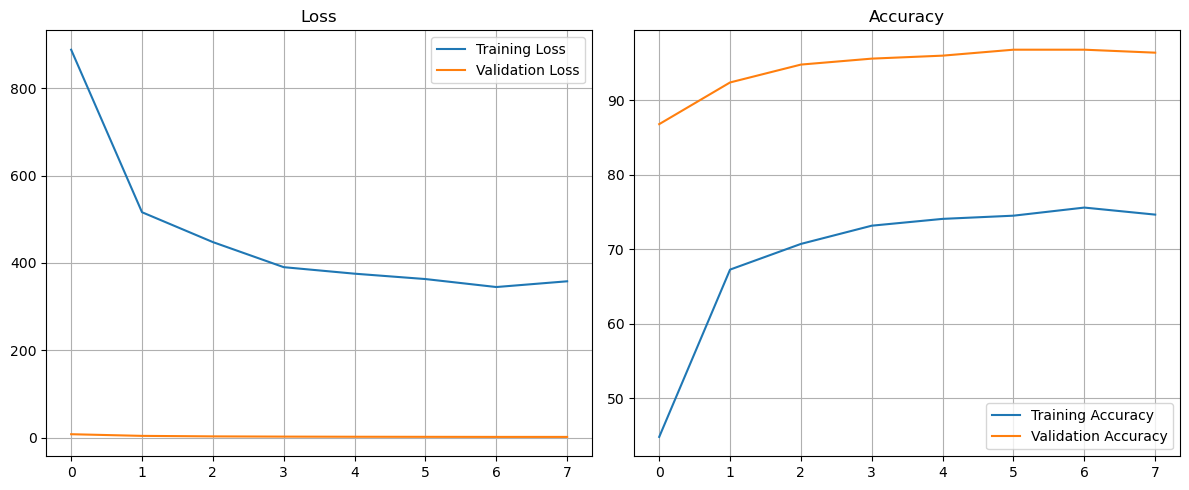

Test Accuracy: 96.40%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      0.80      0.89         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       0.83      1.00      0.91         5
           CLEARWING MOTH       1.00      1.00      1.00         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [13]:
# Import necessary programmes 
from pathlib import Path
import copy
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

from torchvision import transforms, datasets, models
from torchvision.models import ViT_B_16_Weights
from torchvision.transforms.v2 import CutMix

# Set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_root = Path("../data/targeted_augmented_dataset")

# Load weights
weights = ViT_B_16_Weights.DEFAULT

# Standard transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoader
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Cutmix
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets.argmax(dim=1)

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4),
}

# Load ViT model
model = models.vit_b_16(weights=weights)

# Replace classifier
model.heads = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.heads.head.in_features, num_classes)
)

# Freeze all, then unfreeze only encoder layer 11 + head
for name, param in model.named_parameters():
    if "encoder.layers.11" in name or "heads" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.to(device)

# Uniform learning rate (reduced)
param_groups = [
    {'params': model.encoder.layers[11].parameters()},
    {'params': model.heads.parameters()}
]
learning_rate = 5e-4
optimizer = torch.optim.Adam(param_groups, lr=learning_rate, weight_decay=1e-4)

# Training configuration
num_epochs = 8
early_stopping_patience = 3

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

best_val_acc = 0
epochs_no_improve = 0
early_stop = False
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        early_stop = True
        break

# Restore best weights
model.load_state_dict(best_model_wts)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test Evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix & confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")


Reducing the fine-tuning further did not increase the accuracy of the model. 